## SSL (2) vs NSL (0)

### Import Libraries

In [1]:
from util_comp import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import time
import warnings

import xgboost


from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression

# Makes sure we see all columns
pd.set_option('display.max_columns', None)

# ignore warnings
warnings.filterwarnings('ignore')

### Load the data

In [2]:
df = pd.DataFrame(main(retained=True))
print(df.shape)
df.head()

Elapsed time to compute age categorisation: 0 minutes and 0 seconds
Elapsed time to compute correct systematic error: 0 minutes and 11 seconds
Elapsed time to compute load column names: 0 minutes and 0 seconds
Elapsed time to compute clean data: 0 minutes and 0 seconds
Elapsed time to compute categorisation of outcome column: 0 minutes and 3 seconds
Elapsed time to compute change values in catagorical columns: 1 minutes and 57 seconds
Elapsed time to compute Full process: 2 minutes and 12 seconds
(44535, 100)


,YEAR MMS,Q1- Your sex?,Q2- How old are you?,STATUS,In which sector of activity do you work?,"What is the size of your business (in total, all locations combined)? 2009 fake","Q4- (3 to 6 years old) In each of the following age groups, how many children live totally or partially with you?","Q4- (7 to 12 years old) In each of the following age groups, how many children live totally or partially with you?","Q4- (13 to 17 years old) In each of the following age groups, how many children live totally or partially with you?","Q4- (18 years and over) In each of the following age groups, how many children live totally or partially with you?","Q5- Apart from your children, do you have a dependent or sick family member(s) whom you take care of regularly?","Would you say that over the last 12 months, your company's activity has:",Q9- Are you working?,"Q10- Do you have shift work (work organized in successive teams, which take turns at the same workstations) with alternating hours?",Q12- Do you work most often?,Q13- Is the performance of your work taxing on you?-To remain standing for a long time or in an awkward posture,Q13- Is the performance of your work taxing on you?-To carry or move heavy loads,Q13- Is the performance of your work taxing on you?-To perform repetitive gestures,Q13- Is the performance of your work taxing on you?-To work on screen,Q13- Is the performance of your work taxing on you?-Working in the cold / in the heat,Q13- Is the performance of your work taxing on you?-To work in noise,"Q14- During your work, are you in a situation? (Of-breathe toxic products or dust","Q14- During your work, are you in a situation? (Of-handle toxic or dangerous products","Q14- During your work, are you in a situation? (Of-risk a serious fall","Q14- During your work, are you in a situation? (Of-working on machinery that could expose you to injury",Q15- Indicate whether each of the following sentences suits you-My work allows me to learn new things,Q15- Indicate whether each of the following sentences suits you-My job requires working very quickly or very intensely,Q15- Indicate whether each of the following sentences suits you-My job requires long periods of concentration,Q15- Indicate whether each of the following sentences suits you-My job is physically tiring,Q15- Indicate whether each of the following sentences suits you-My work is nervously tiring,Q15- Indicate whether each of the following sentences suits you-I am satisfied with my work,Q15- Indicate whether each of the following sentences suits you-In my job I have the opportunity to make decisions,"Q15- Indicate whether each of the following sentences suits you-At times, I have difficulty managing priorities",Q15- Indicate whether each of the following sentences suits you-I feel recognized by my hierarchy,Q15- Indicate whether each of the following sentences suits you-I have the opportunity to develop my professional skills,Q15- Indicate whether each of the following sentences suits you-There is good understanding where I work,Q15- Indicate whether each of the following sentences suits you-I have a well-suited workstation,Q15- Indicate whether each of the following sentences suits you-I systematically seek to improve the way I work,Q15- Indicate whether each of the following sentences suits you-My company takes care of the well-being of its employees,Q15- Indicate whether each of the following sentences suits you-Security is a priority for my business,"Q15- Indicate whether each of the following sentences suits you-In the event of a problem, I can count on my supervisor","Would you say that over the last 12 months, your pace of work has:",Q16- And for each of these sentences?-I would recommend my company to a friend,Q16- And for each of these sentences?-I am proud to work in my company,"Q17- At work, does it happen to you: (D-have decreased alertness, lack of attention","Q17- At work, does it happen to you: (D-e receiving hurtful or aggressive remarks within the company","Q17- At 

In [3]:
# drop rows where 'YEAR MMS' is 1 or 10
df = df[df['YEAR MMS'] != 1]
df = df[df['YEAR MMS'] != 10]

In [4]:
df.shape

(37681, 100)

In [5]:
# drop column YEAR MMS
df = df.drop(columns=['YEAR MMS'])

In [6]:
# one hot encode

df = pd.get_dummies(df)
df.head()

,"Q4- (3 to 6 years old) In each of the following age groups, how many children live totally or partially with you?","Q4- (7 to 12 years old) In each of the following age groups, how many children live totally or partially with you?","Q4- (13 to 17 years old) In each of the following age groups, how many children live totally or partially with you?","Q4- (18 years and over) In each of the following age groups, how many children live totally or partially with you?",outcome,Q1- Your sex?_A man,Q1- Your sex?_A woman,Q2- How old are you?_18 - 30,Q2- How old are you?_30 - 39,Q2- How old are you?_40 - 44,Q2- How old are you?_45 - 49,Q2- How old are you?_50 - 55,Q2- How old are you?_56 - 70,STATUS_AM Technicians,STATUS_Employees,STATUS_Frames,STATUS_Workers,In which sector of activity do you work?_Construction,In which sector of activity do you work?_Design office and engineering,In which sector of activity do you work?_Human health and social action,In which sector of activity do you work?_Industry,In which sector of activity do you work?_Other businesses,In which sector of activity do you work?_Retail business,In which sector of activity do you work?_Services,"In which sector of activity do you work?_Transport, energy, telecommunications",In which sector of activity do you work?_Wholesale trade (all businesses in 206),"What is the size of your business (in total, all locations combined)? 2009 fake_10 to 49 employees","What is the size of your business (in total, all locations combined)? 2009 fake_250 to 999 employees","What is the size of your business (in total, all locations combined)? 2009 fake_50 to 249 employees","What is the size of your business (in total, all locations combined)? 2009 fake_Less than 10 employees","Q5- Apart from your children, do you have a dependent or sick family member(s) whom you take care of regularly?_No","Q5- Apart from your children, do you have a dependent or sick family member(s) whom you take care of regularly?_Yes, who lives elsewhere","Q5- Apart from your children, do you have a dependent or sick family member(s) whom you take care of regularly?_Yes, who lives with me","Would you say that over the last 12 months, your company's activity has:_Accelerated","Would you say that over the last 12 months, your company's activity has:_Do not know","Would you say that over the last 12 months, your company's activity has:_Slow down","Would you say that over the last 12 months, your company's activity has:_Stabilized",Q9- Are you working?_Full time,Q9- Are you working?_Part time,"Q10- Do you have shift work (work organized in successive teams, which take turns at the same workstations) with alternating hours?_No","Q10- Do you have shift work (work organized in successive teams, which take turns at the same workstations) with alternating hours?_Yes",Q12- Do you work most often?_At customers,Q12- Do you work most often?_At home teleworking,Q12- Do you work most often?_In a commercial premises or agency,Q12- Do you work most often?_In a shared office (3 to 5 people),Q12- Do you work most often?_In a shared work space - co-working,Q12- Do you work most often?_In a vehicle,"Q12- Do you work most often?_In a workshop, a technical room",Q12- Do you work most often?_In an office alone or in pairs,"Q12- Do you work most often?_In an open space, a tray",Q12- Do you work most often?_Outside-outside,Q13- Is the performance of your work taxing on you?-To remain standing for a long time or in an awkward posture_Most of the time,Q13- Is the performance of your work taxing on you?-To remain standing for a long time or in an awkward posture_Never,Q13- Is the performance of your work taxing on you?-To remain standing for a long time or in an awkward posture_Occasionally,Q13- Is the performance of your work taxing on you?-To remain standing for a long time or in an awkward posture_Rarely,Q13- Is the performance of your work taxing on you?-To carry or move heavy loads_Most of the time,Q13- Is the performance of your work tax

#### split data to train and test sets

In [7]:
data = df

# Split the data for training and evaluation
# X: features with the outcome column removed, where outcome is 0 or 2
# y: outcome column

# get the rows withs outcome 0 or 2
X = data[(data['outcome'] == 0) | (data['outcome'] == 2)].drop('outcome', axis=1, inplace=False)
X.columns = [str(i) for i in X.columns]
y = data[(data['outcome'] == 0) | (data['outcome'] == 2)]['outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


#### Train the Random Forest model

In [8]:
# Fit RF (blackbox) model
t1 = time.time()
sl = RandomForestClassifier(class_weight='balanced')
sl.fit(X_train, y_train)
t2 = time.time()
print(time_e(t1, t2, "fitting RF model"))

Elapsed time to compute fitting RF model: 0 minutes and 3 seconds


In [9]:
y_pred = sl.predict(X_test)
y_pred_proba = sl.predict_proba(X_test)

In [10]:
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy of test: {accuracy_score(y_test, y_pred)}")
print(f"Accuracy of train: {accuracy_score(y_train, sl.predict(X_train))}")

# ROAUC

print(f"ROAUC: {roc_auc_score(y_test, y_pred_proba[:,1])}")
print(f"Confusin matrix: \n{confusion_matrix(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

F1 Score: 0.4758082743033544
Accuracy of test: 0.872644098810613
Accuracy of train: 0.9999542459736457
ROAUC: 0.6845940748325858
Confusin matrix: 
[[4762    0]
 [ 696    7]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      4762
           2       1.00      0.01      0.02       703

    accuracy                           0.87      5465
   macro avg       0.94      0.50      0.48      5465
weighted avg       0.89      0.87      0.81      5465



## Explanantion using SHAP

In [11]:
# Calculate shapley values for test data
start_index = 0
end_index = 10

# time to run 10 samples
s_time = time.time()
explainer = shap.TreeExplainer(sl)

shap_values = explainer.shap_values(X_test[start_index:end_index]) # 0 - 9
e_time = time.time()
time_e(s_time, e_time, f"Shapley values for test data[{start_index}:{end_index}]")
X_test[start_index:end_index]

,"Q4- (3 to 6 years old) In each of the following age groups, how many children live totally or partially with you?","Q4- (7 to 12 years old) In each of the following age groups, how many children live totally or partially with you?","Q4- (13 to 17 years old) In each of the following age groups, how many children live totally or partially with you?","Q4- (18 years and over) In each of the following age groups, how many children live totally or partially with you?",Q1- Your sex?_A man,Q1- Your sex?_A woman,Q2- How old are you?_18 - 30,Q2- How old are you?_30 - 39,Q2- How old are you?_40 - 44,Q2- How old are you?_45 - 49,Q2- How old are you?_50 - 55,Q2- How old are you?_56 - 70,STATUS_AM Technicians,STATUS_Employees,STATUS_Frames,STATUS_Workers,In which sector of activity do you work?_Construction,In which sector of activity do you work?_Design office and engineering,In which sector of activity do you work?_Human health and social action,In which sector of activity do you work?_Industry,In which sector of activity do you work?_Other businesses,In which sector of activity do you work?_Retail business,In which sector of activity do you work?_Services,"In which sector of activity do you work?_Transport, energy, telecommunications",In which sector of activity do you work?_Wholesale trade (all businesses in 206),"What is the size of your business (in total, all locations combined)? 2009 fake_10 to 49 employees","What is the size of your business (in total, all locations combined)? 2009 fake_250 to 999 employees","What is the size of your business (in total, all locations combined)? 2009 fake_50 to 249 employees","What is the size of your business (in total, all locations combined)? 2009 fake_Less than 10 employees","Q5- Apart from your children, do you have a dependent or sick family member(s) whom you take care of regularly?_No","Q5- Apart from your children, do you have a dependent or sick family member(s) whom you take care of regularly?_Yes, who lives elsewhere","Q5- Apart from your children, do you have a dependent or sick family member(s) whom you take care of regularly?_Yes, who lives with me","Would you say that over the last 12 months, your company's activity has:_Accelerated","Would you say that over the last 12 months, your company's activity has:_Do not know","Would you say that over the last 12 months, your company's activity has:_Slow down","Would you say that over the last 12 months, your company's activity has:_Stabilized",Q9- Are you working?_Full time,Q9- Are you working?_Part time,"Q10- Do you have shift work (work organized in successive teams, which take turns at the same workstations) with alternating hours?_No","Q10- Do you have shift work (work organized in successive teams, which take turns at the same workstations) with alternating hours?_Yes",Q12- Do you work most often?_At customers,Q12- Do you work most often?_At home teleworking,Q12- Do you work most often?_In a commercial premises or agency,Q12- Do you work most often?_In a shared office (3 to 5 people),Q12- Do you work most often?_In a shared work space - co-working,Q12- Do you work most often?_In a vehicle,"Q12- Do you work most often?_In a workshop, a technical room",Q12- Do you work most often?_In an office alone or in pairs,"Q12- Do you work most often?_In an open space, a tray",Q12- Do you work most often?_Outside-outside,Q13- Is the performance of your work taxing on you?-To remain standing for a long time or in an awkward posture_Most of the time,Q13- Is the performance of your work taxing on you?-To remain standing for a long time or in an awkward posture_Never,Q13- Is the performance of your work taxing on you?-To remain standing for a long time or in an awkward posture_Occasionally,Q13- Is the performance of your work taxing on you?-To remain standing for a long time or in an awkward posture_Rarely,Q13- Is the performance of your work taxing on you?-To carry or move heavy loads_Most of the time,Q13- Is the performance of your work taxing on y

In [12]:
y_test[start_index:end_index]

6939     0
4968     0
14889    0
34533    0
38641    0
8567     0
29614    0
34998    0
28555    0
27620    0
Name: outcome, dtype: int64

### SHAP Values

In [13]:
print(shap_values[0].shape)
shap_values

(333, 2)


array([[[ 2.34250120e-03, -2.34250120e-03],
        [ 2.35846610e-04, -2.35846620e-04],
        [ 8.10648663e-04, -8.10648706e-04],
        ...,
        [ 3.35702247e-03, -3.35702248e-03],
        [ 9.68684283e-05, -9.68684332e-05],
        [ 2.86105580e-03, -2.86105579e-03]],

       [[ 4.35528257e-03, -4.35528257e-03],
        [ 3.54108327e-04, -3.54108171e-04],
        [ 4.92682805e-04, -4.92682675e-04],
        ...,
        [ 4.24722075e-03, -4.24722074e-03],
        [ 5.71615344e-04, -5.71615321e-04],
        [ 2.87642399e-03, -2.87642399e-03]],

       [[ 2.98713974e-03, -2.98713974e-03],
        [ 1.42776650e-03, -1.42776650e-03],
        [ 9.33600734e-04, -9.33600737e-04],
        ...,
        [ 2.17085612e-03, -2.17085612e-03],
        [ 6.08385013e-04, -6.08385013e-04],
        [ 2.48684521e-03, -2.48684521e-03]],

       ...,

       [[ 2.23045061e-03, -2.23045061e-03],
        [ 1.61301516e-03, -1.61301516e-03],
        [ 2.83050929e-04, -2.83050918e-04],
        ...,
     

In [14]:
shap.initjs()
# Force plot
prediction = sl.predict(X_test[start_index:end_index])[0]
print(f"The sl predicted: {prediction}")
shap.force_plot(explainer.expected_value[1],
                shap_values[...,1],
                X_test[start_index:end_index])  # for values

The sl predicted: 0


### Summary of Variables that affected the prediction using SHAP

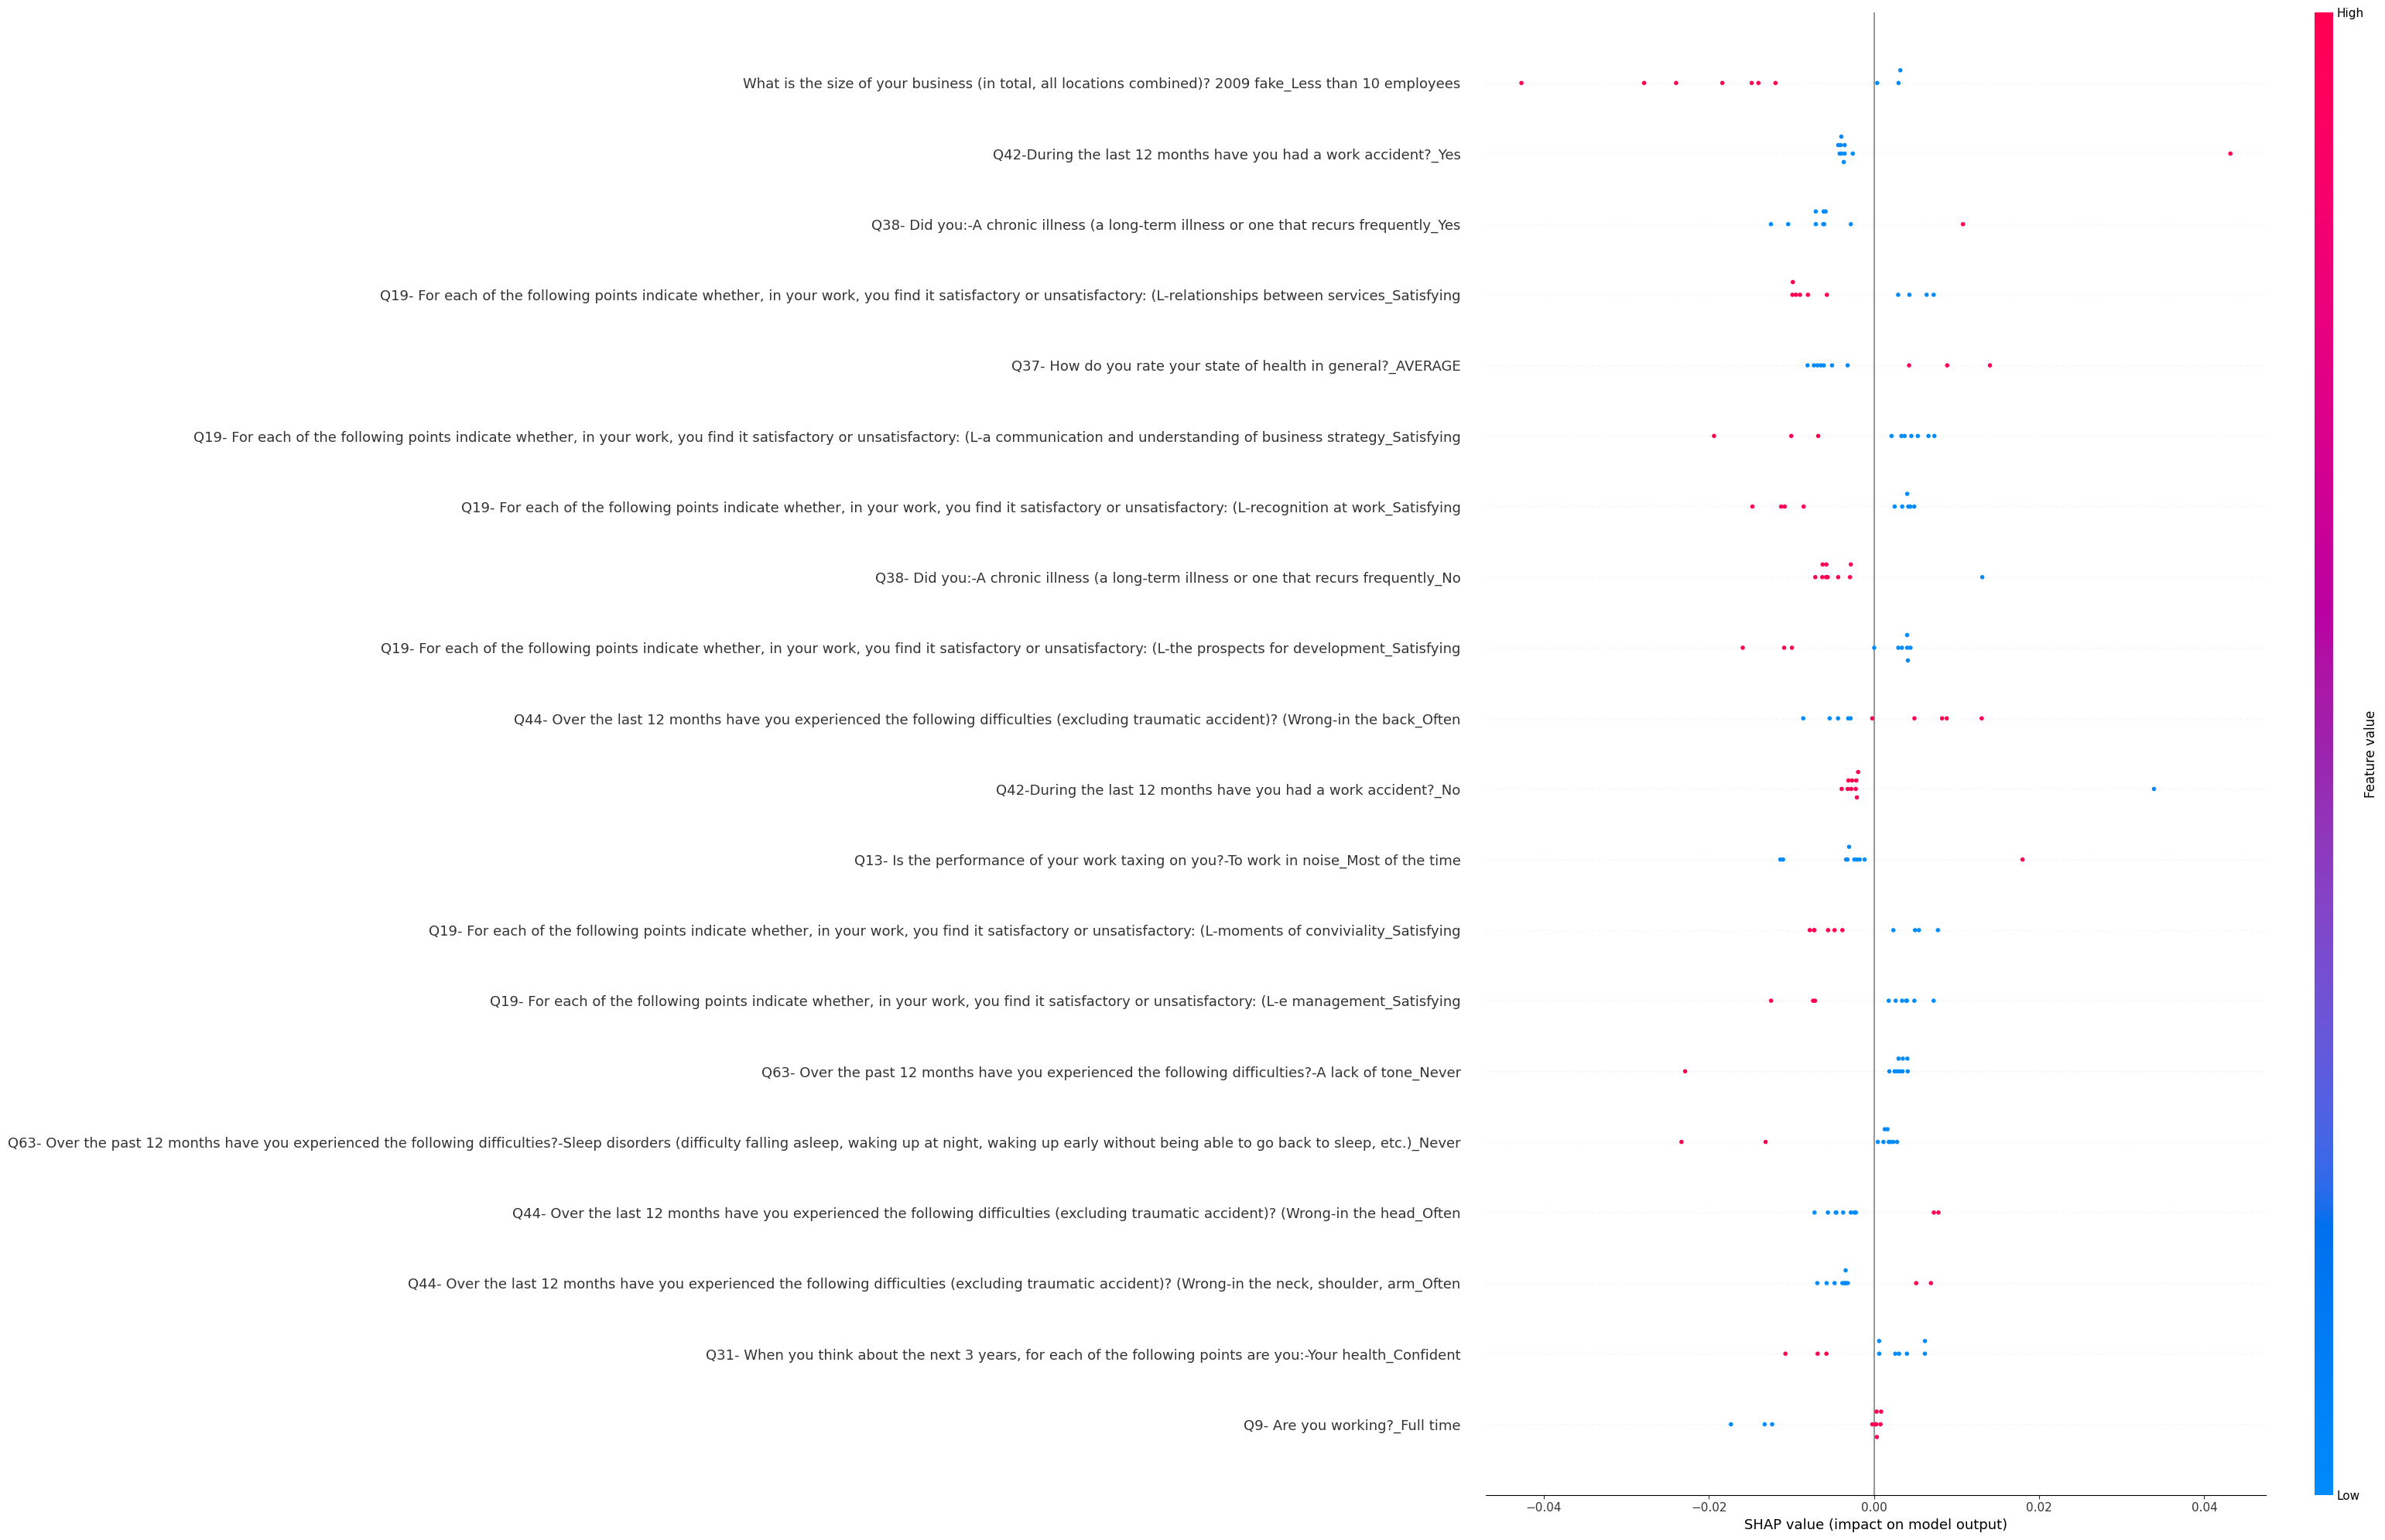

In [15]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_size=(32,20), show=False)
plt.savefig('outputs/02_02_shap/summary_plot_for_10_samples.png', bbox_inches='tight')
plt.show()

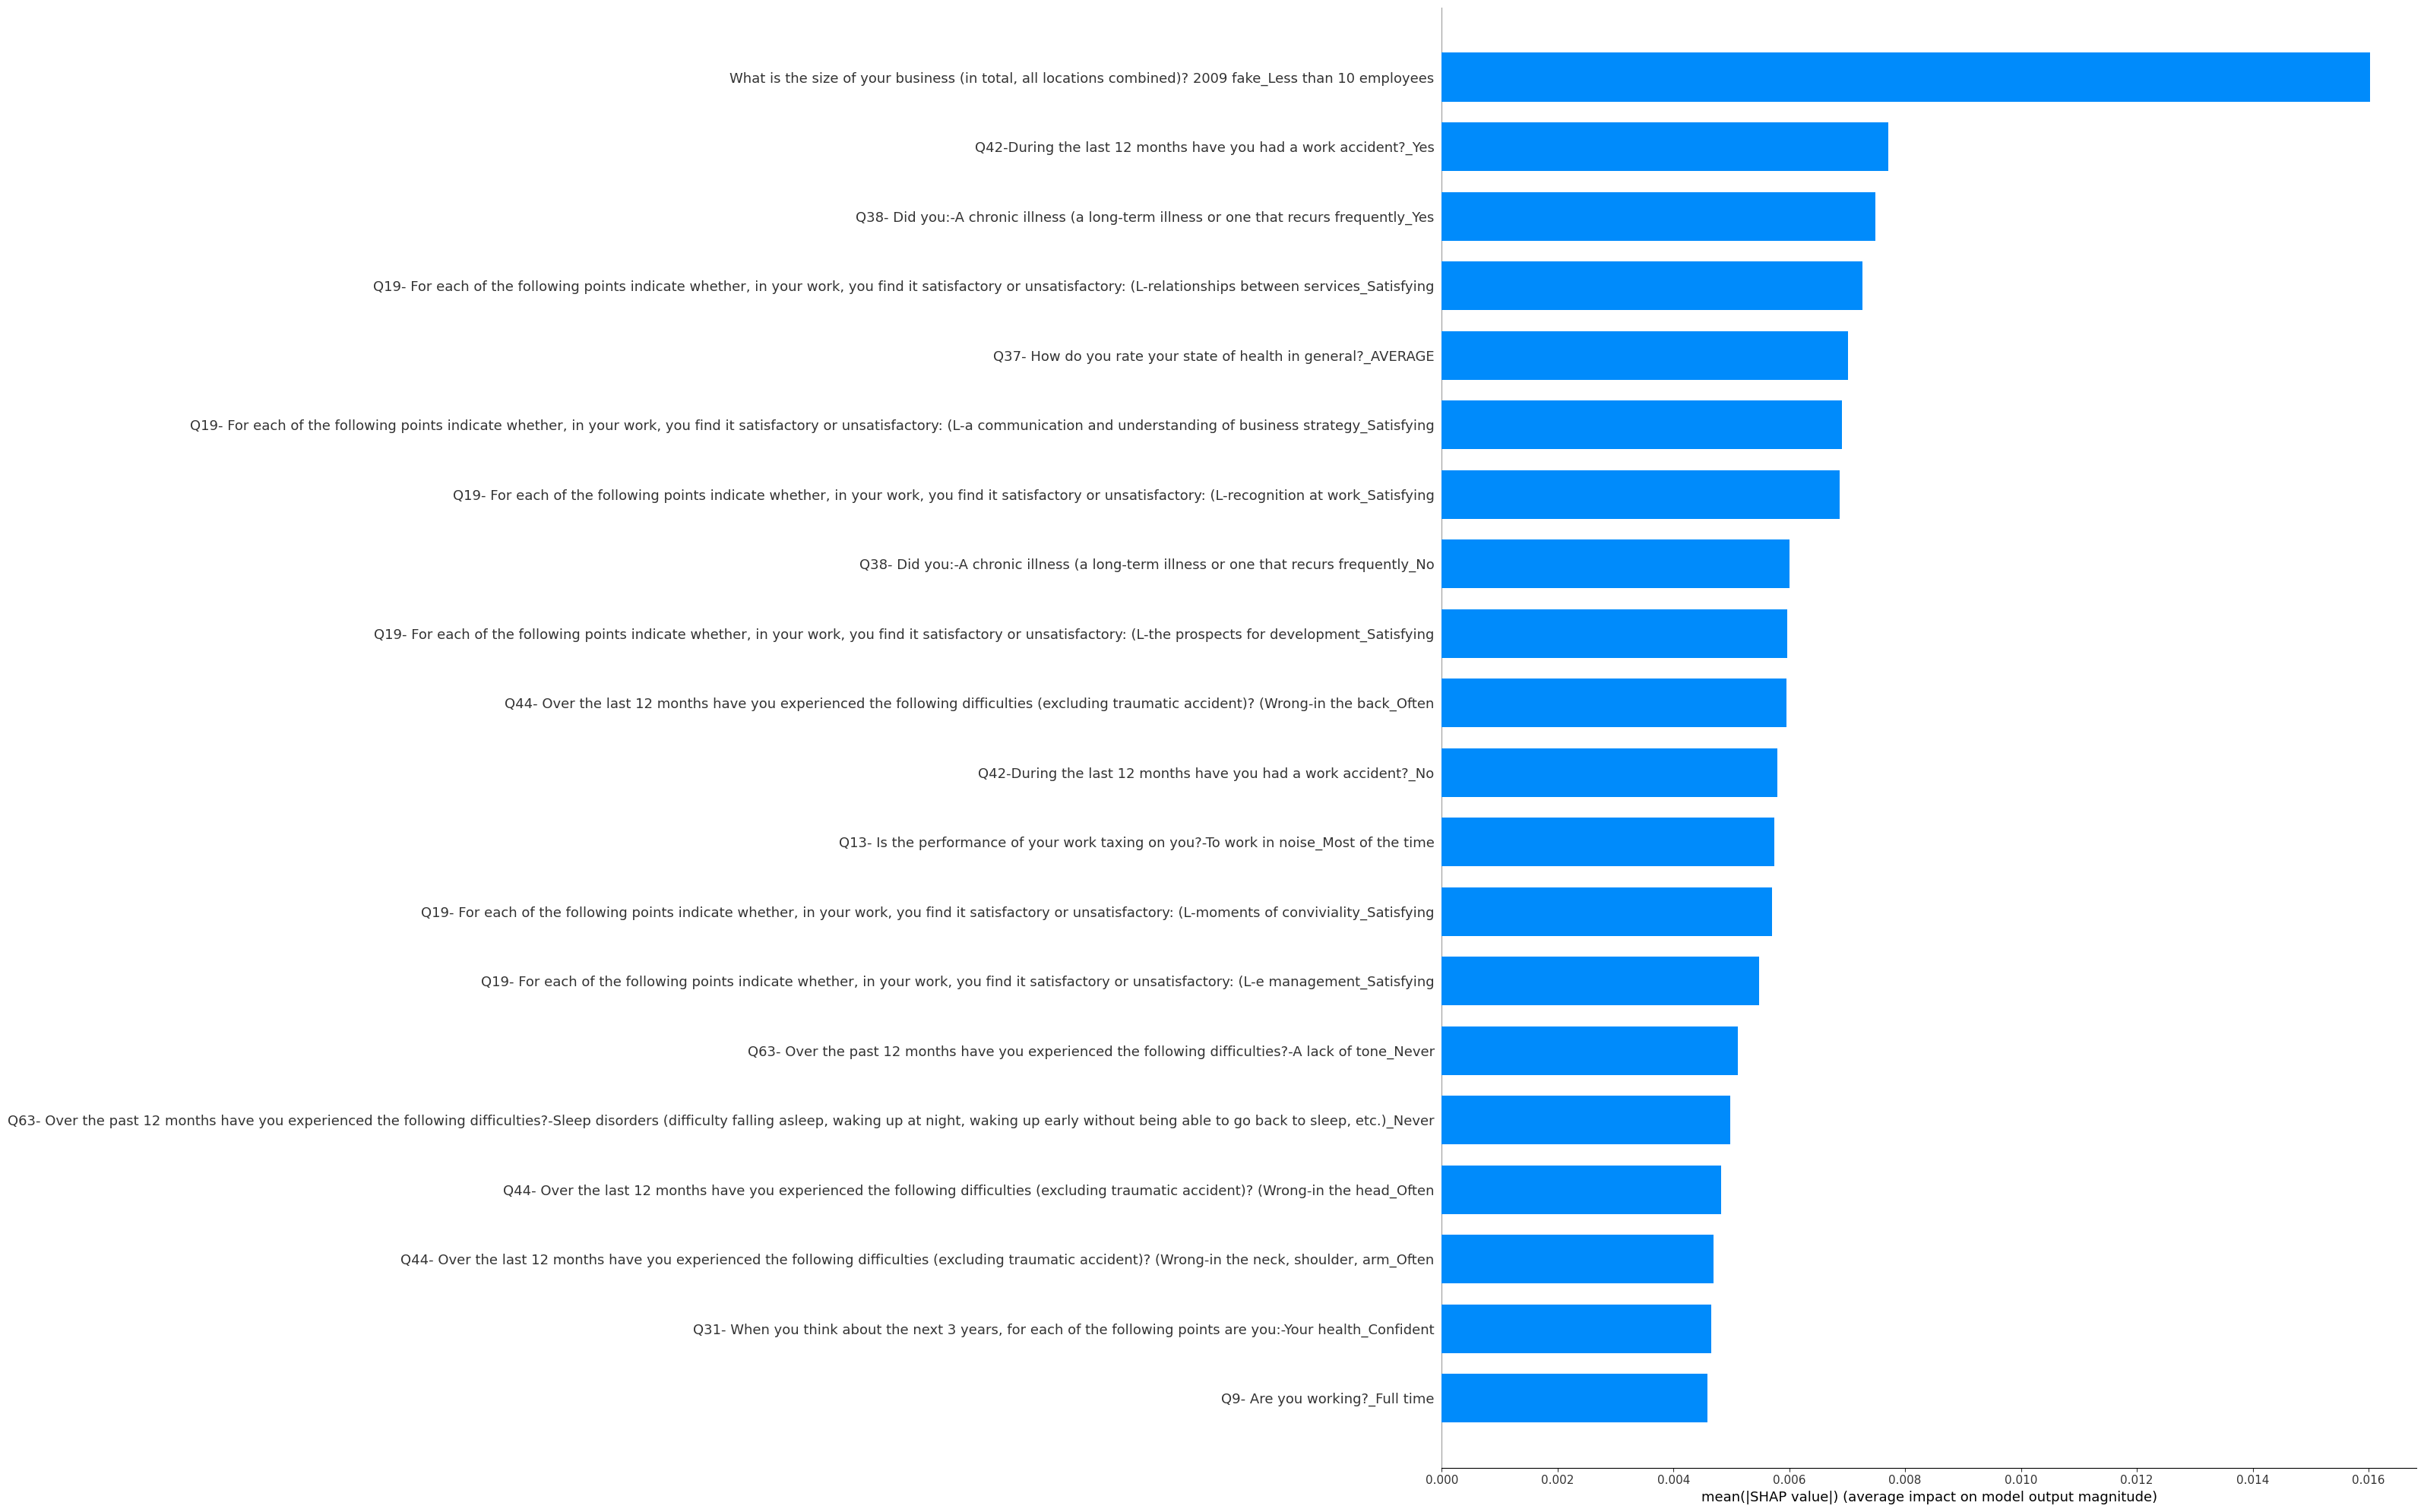

In [16]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_type="bar", plot_size=(32,20), show=False)
plt.savefig('outputs/02_02_shap/summary_plot_bar_for_10_samples.png', bbox_inches='tight')
plt.show()

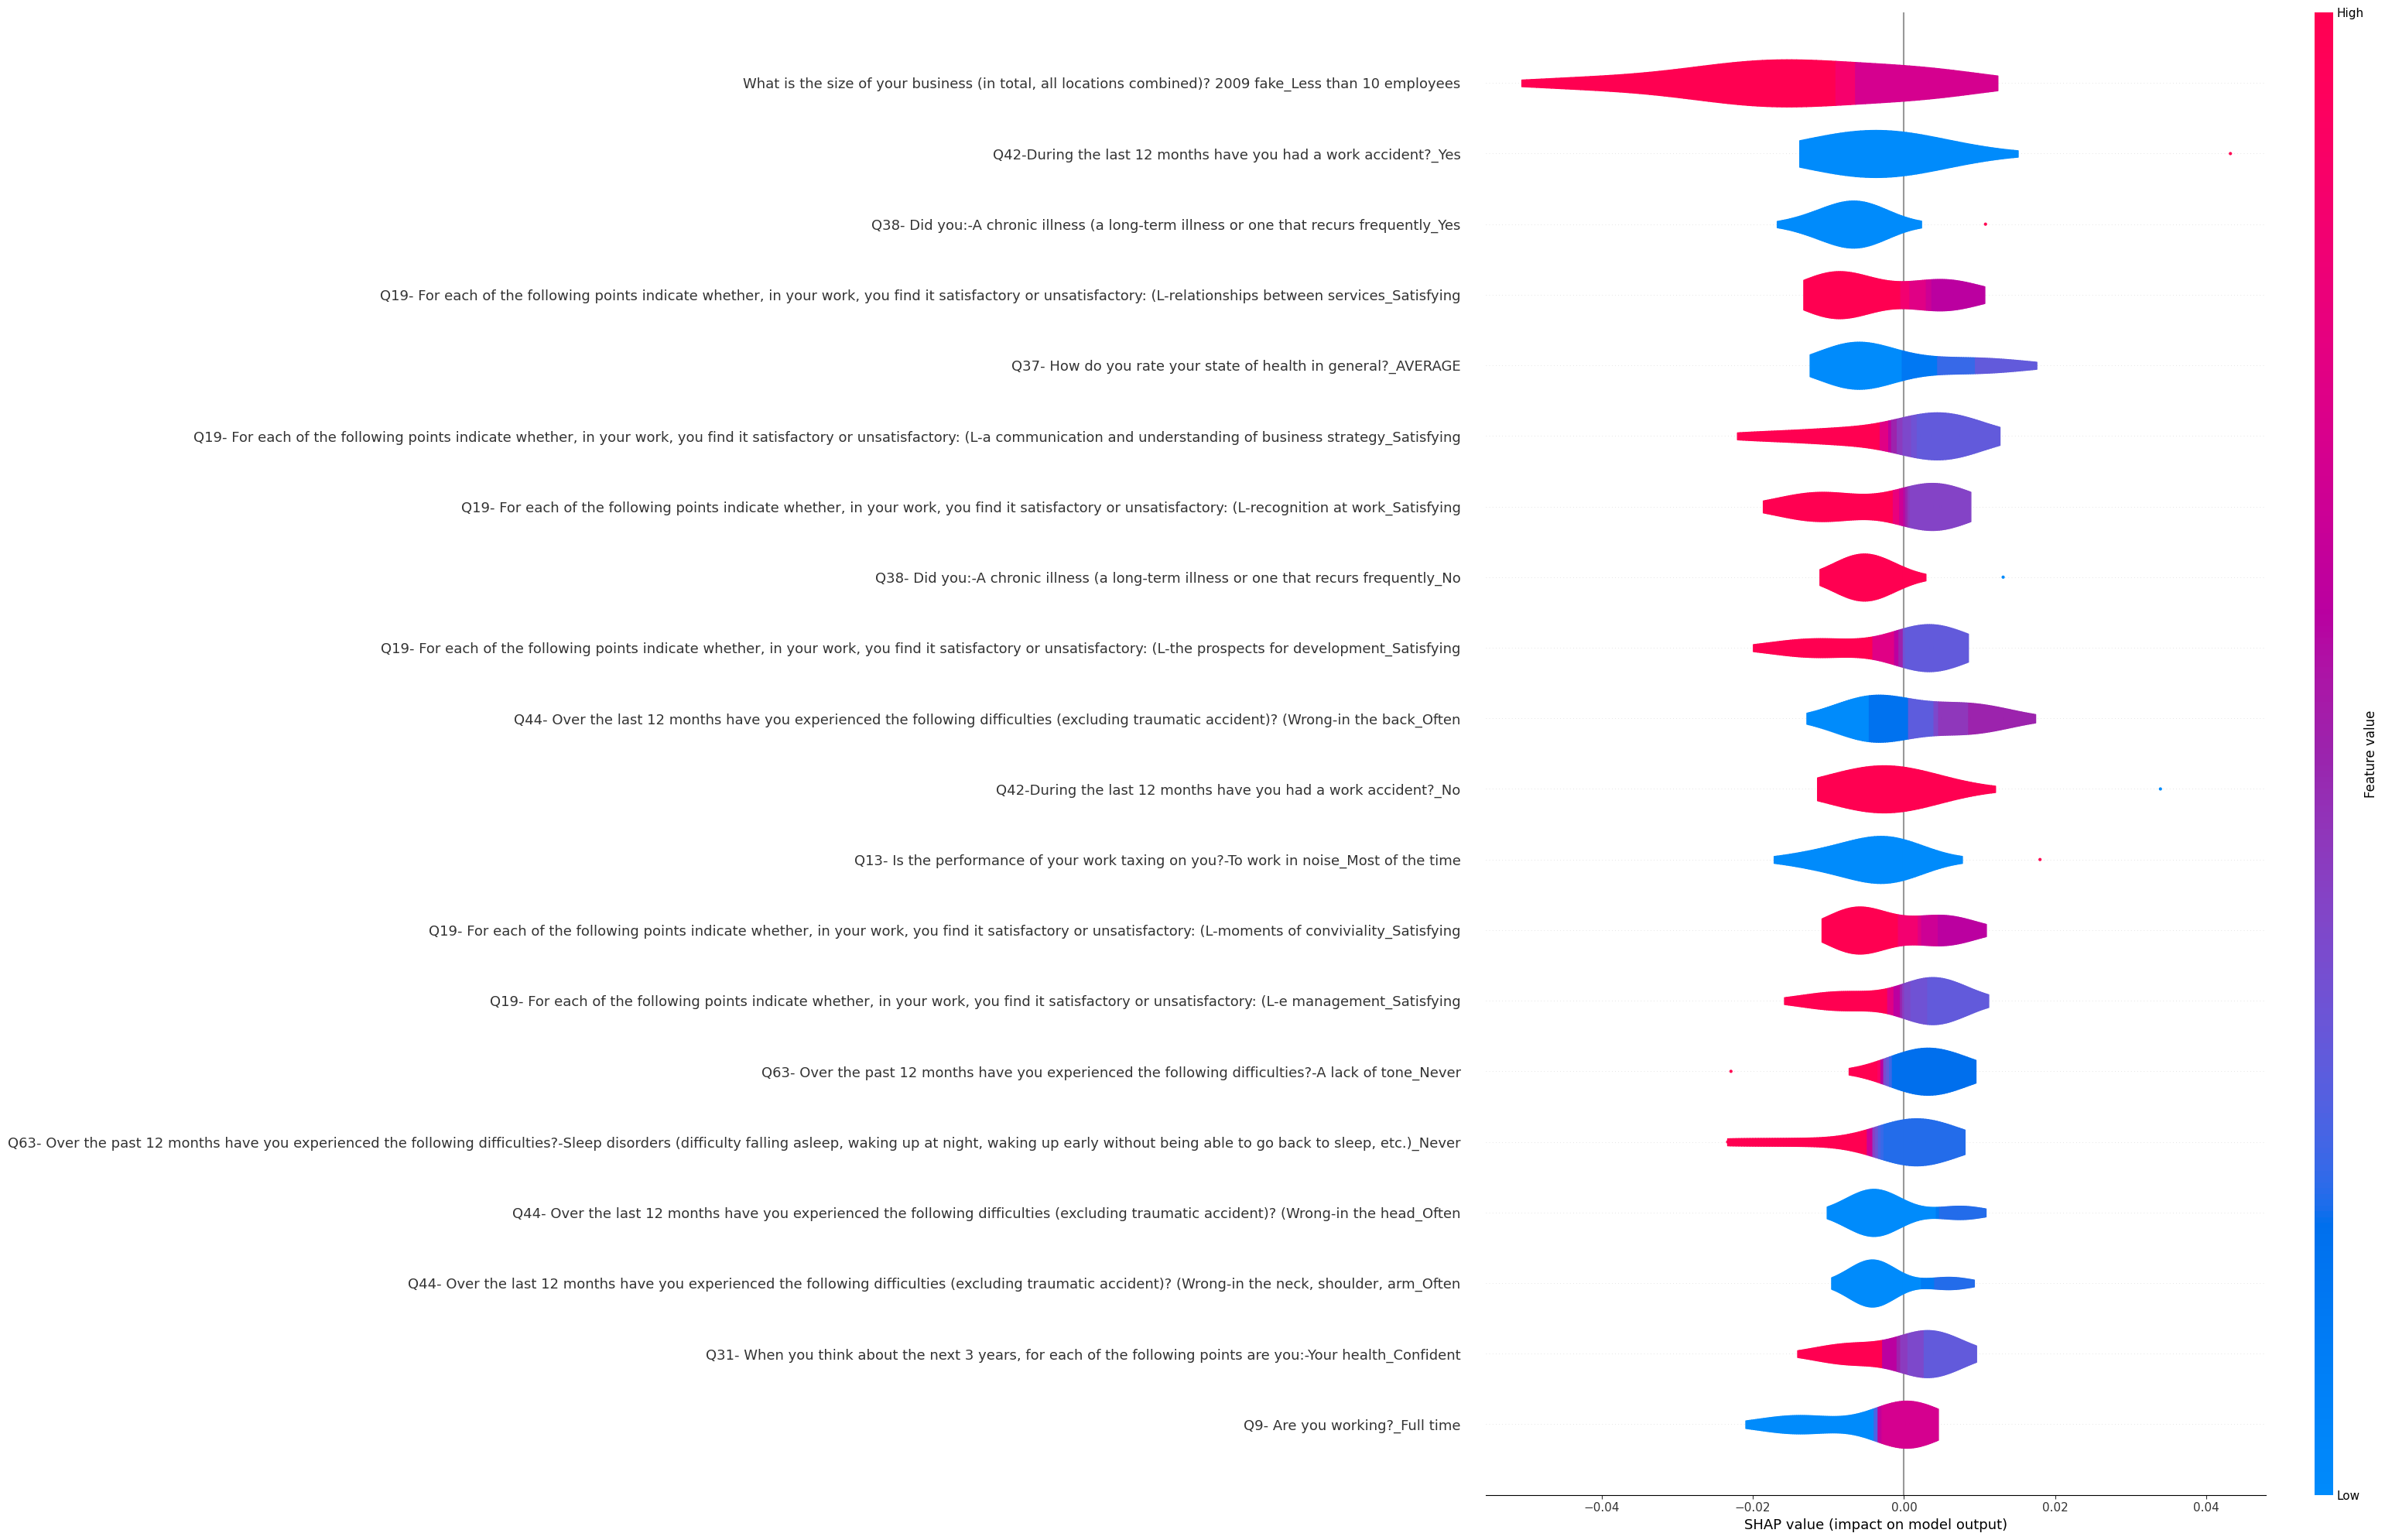

In [17]:
shap.summary_plot(shap_values[...,1], X_test[start_index:end_index], plot_type="violin", plot_size=(32,20), show=False)
plt.savefig('outputs/02_02_shap/summary_plot_violin_for_10_samples.png', bbox_inches='tight')
plt.show()

### XGBoost
max_depth = 3

In [18]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({"eta": 1, "max_depth": 3, "base_score": 0, "lambda": 0}, Xd, 1)

print("Model error =", np.linalg.norm(y - model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 105.33094776396656
0:[Q42-During the last 12 months have you had a work accident?_Yes<1] yes=1,no=2,missing=2,gain=146.648071,cover=27321
	1:[Q19- For each of the following points indicate whether, in your work, you find it satisfactory or unsatisfactory: (L-recognition at work_Satisfying<1] yes=3,no=4,missing=4,gain=124.990479,cover=26531
		3:[Q63- Over the past 12 months have you experienced the following difficulties?-A lack of tone_Never<1] yes=7,no=8,missing=8,gain=61.4838867,cover=15698
			7:leaf=0.308791786,cover=13433
			8:leaf=0.130684331,cover=2265
		4:[Q37- How do you rate your state of health in general?_AVERAGE<1] yes=9,no=10,missing=10,gain=23.3483887,cover=10833
			9:leaf=0.121136367,cover=8800
			10:leaf=0.240039349,cover=2033
	2:[Q19- For each of the following points indicate whether, in your work, you find it satisfactory or unsatisfactory: (L-a balance between private life and professional life_Satisfying<1] yes=5,no=6,missing=6,gain=16.4034424,cover=79

In [19]:
# Calculate model accuracy and F1 score

y_pred = model.predict(Xd) > 0.5
print(f"F1 Score {f1_score(y, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y, y_pred)}")

F1 Score 0.31077299065788955
Accuracy 0.8657076973756451


In [20]:
pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)
shap_values = explanation.values

# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

5.9604645e-08

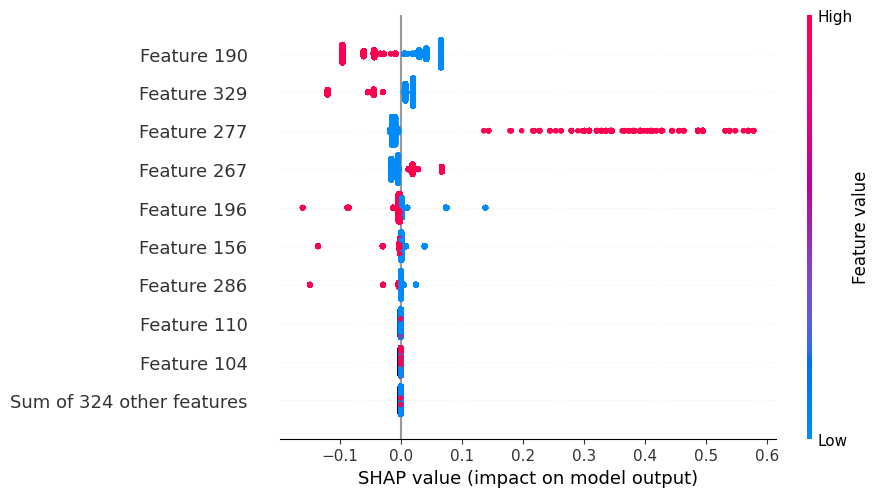

In [21]:
"""
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.
The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution
of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).
"""
shap.plots.beeswarm(explanation, show=False)
plt.savefig('outputs/02_02_shap/shap_beeswarm_plot_xg_4.png', bbox_inches='tight')
plt.show()

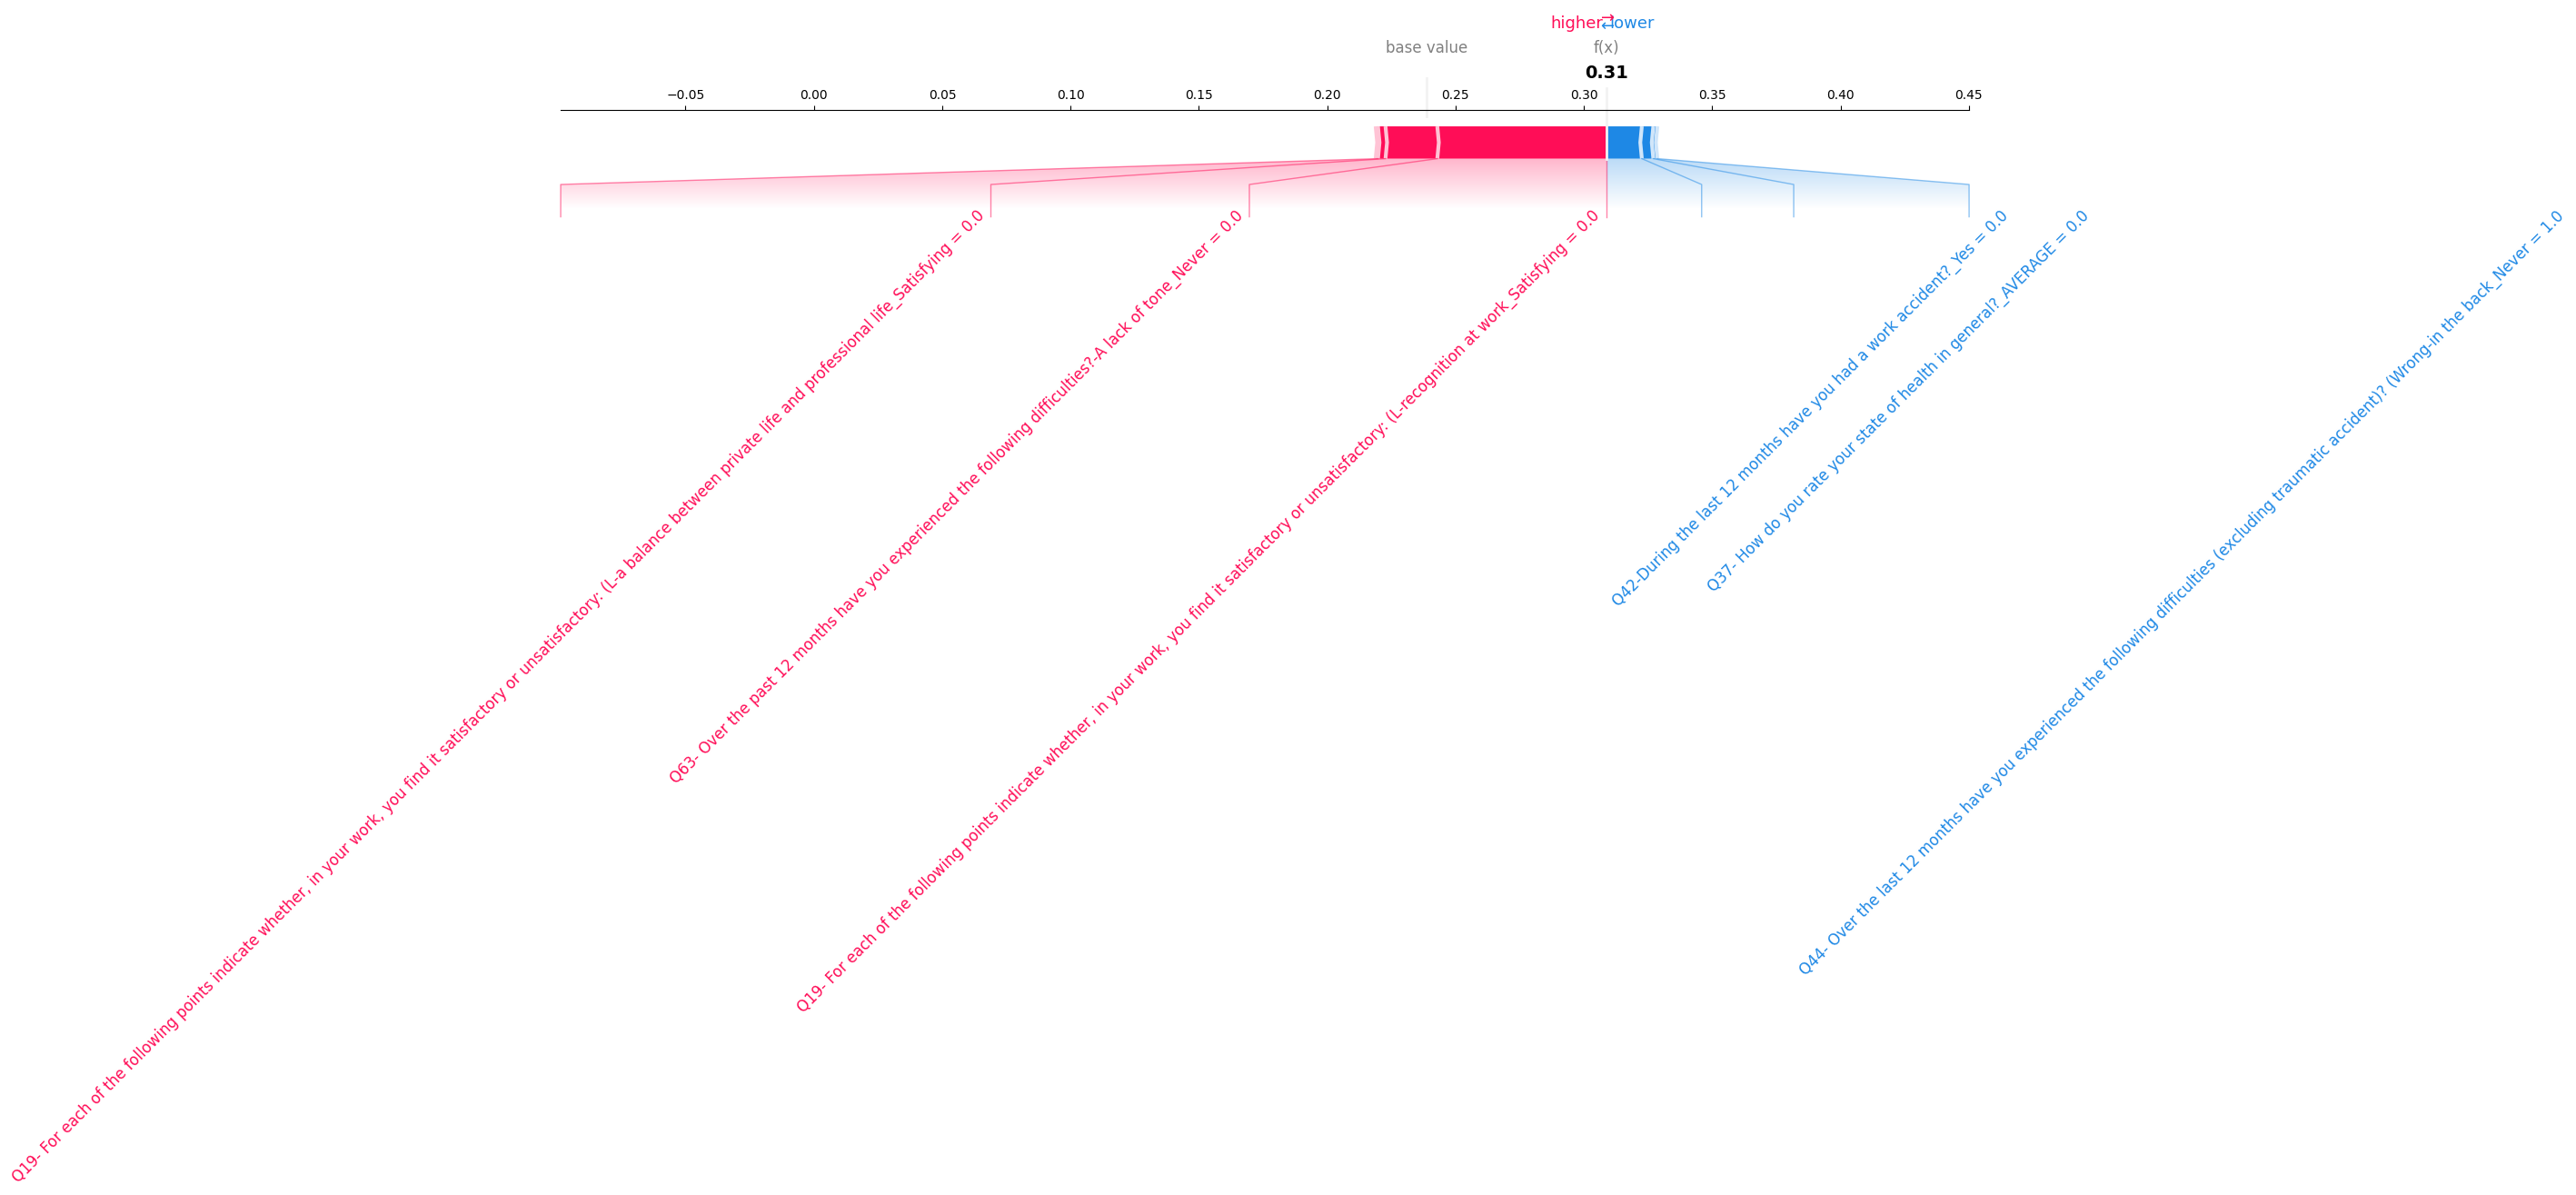

In [22]:
shap.force_plot(explanation.base_values[0], shap_values[0,:], X.iloc[0,:], text_rotation=45, matplotlib=True, show= False) # shows the shap values for the second prediction
plt.savefig('outputs/02_02_shap/shap_force_plot_xg_4.png', bbox_inches='tight')
plt.show()

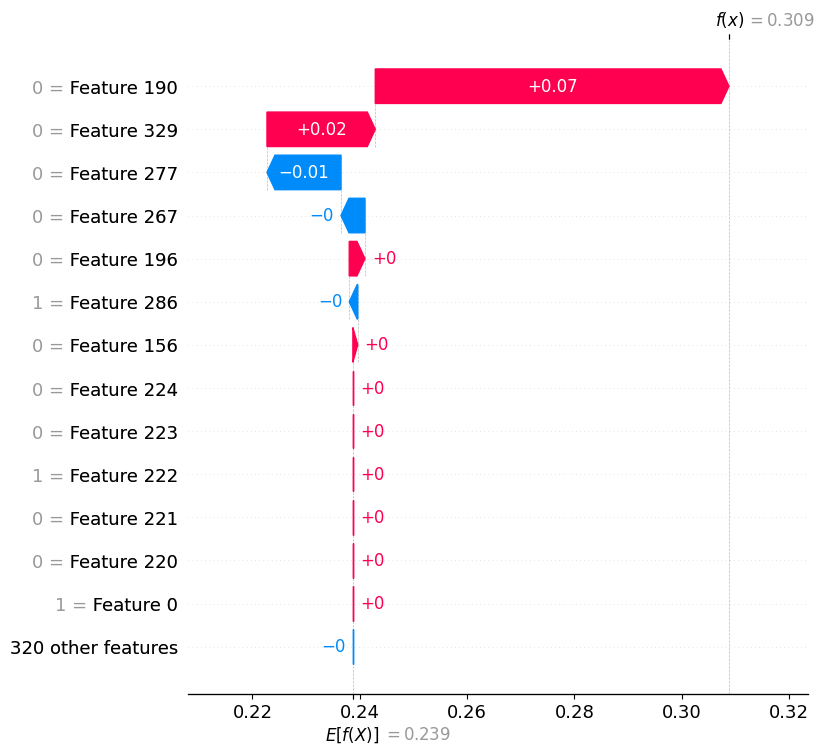

In [23]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(explanation[0,:], max_display=14, show=False)
plt.figsize=(32,18)
plt.savefig('outputs/02_02_shap/shap_waterfall_plot_xg_4.png', bbox_inches='tight')
plt.show()

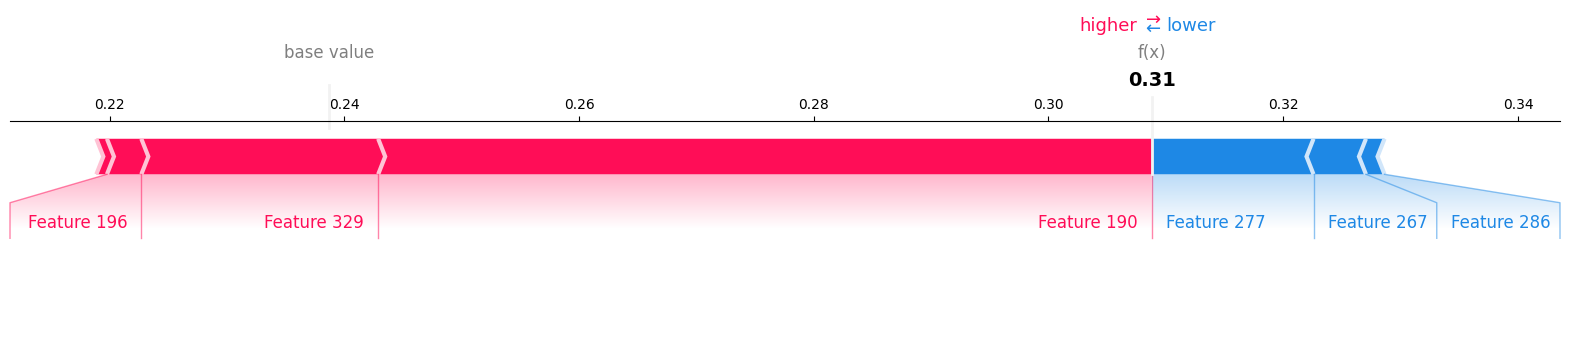

In [24]:
shap.plots.force(explainer.expected_value, shap_values[0, ...], show= False, matplotlib=True) # shap_values[0, ...] is the SHAP values for the first instance in the dataset ... is a numpy slice that means "all of the other axes"
plt.savefig('outputs/02_02_shap/shap_force_plot_xg_4_2.png', bbox_inches='tight')
plt.show()

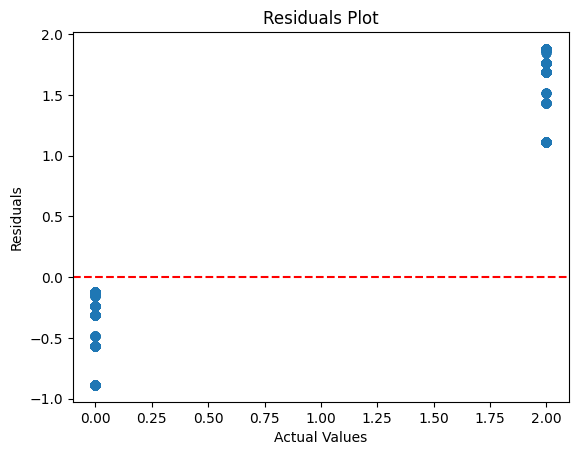

In [25]:
residuals = y - model.predict(Xd)
plt.scatter(y, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# save the plot
plt.savefig('outputs/02_02_shap/residuals_plot.png', bbox_inches='tight')
plt.show()